# Extra Trees Model Training (from scraped GitHub code)

This notebook trains an **Extra Trees** model on the metrics dataset 


## 1) Load Lib

In [2]:
# Step 1: Imports
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 2) Load dataset

In [3]:
df = pd.read_csv('../data/processed/dataset_processed.csv')
df.head()

,average_cyclomatic_complexity,average_methods_per_class,avg_line_length,boolean_expression_avg_terms,call_graph_density,classes,classes_with_inheritance,comment_code_mismatch_score,comment_lines,comment_percentage,decision_density,documentation_coverage,external_vs_internal_field_access_ratio,file_age_days,file_path,functions,global_usages_total,globals_declared,halstead_difficulty,halstead_effort,halstead_estimated_bugs,halstead_volume,inter_file_coupling,large_parameter_list_indicator,lazy_class_indicator,lines_added,lines_of_code,long_method_indicator,max_cyclomatic_ratio,max_intra_file_call_depth,max_line_length,max_lines_per_function,max_nesting_level,mean_cyclomatic_ratio,mean_lines_per_function,mean_param_entropy,methods,nesting_variance,num_authors,pep8_violations,percent_lines_over_80,semantic_todo_density,source_lines,test_files_found,test_function_count,test_lines,test_to_source_ratio,todo_fixme_count,todo_fixme_semantic_density,total_imports,unit_test_presence,y_FeatureEnvy,y_FormattingIssues,y_GlobalStateAbuse,y_GodClass,y_LargeParameterList,y_LazyClass,y_LongMethod,y_MisleadingComments,y_PoorDocumentation,y_SpaghettiCode,y_UnstableModule,y_UntestedCode,y_any_smell
0,0.360756,0.0,0.394464,0.0,0.333333,0.00000,0.000,0.0,0.125000,0.167,0.623314,0.0,0.033846,0.0,awesome-python\sort.py,0.025974,0.00000,0.000000,0.101876,0.010526,0.026215,0.026210,0.105263,False,False,0.011375,0.011375,False,0.172667,0.125,0.115646,0.005102,0.3,0.254697,0.118520,0.000000,0.0,0.12288,0.0,0.002972,0.035704,0.0,0.006111,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,1,0,0,1,1
1,0.166203,0.0,0.369089,0.0,0.000000,0.00000,0.000,0.0,0.017857,0.095,0.326629,0.0,0.009231,0.0,fastapi\pdm_build.py,0.012987,0.00625,0.038462,0.000000,0.000000,0.000000,0.000000,0.017544,False,False,0.002741,0.002741,False,0.166667,0.000,0.083900,0.001749,0.1,0.260960,0.045879,0.613327,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.001944,1.0,1.0,1.0,0.071766,0.0,0.0,0.038961,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1
2,0.110617,0.0,0.242215,0.0,0.000000,0.04878,0.050,0.0,0.000000,0.000,0.163200,0.0,0.003077,0.0,fastapi\docs_src\additional_responses\tutorial...,0.000000,0.00625,0.038462,0.000000,0.000000,0.000000,0.000000,0.017544,False,False,0.003015,0.003015,False,0.333333,0.000,0.097506,0.000583,0.1,0.521921,0.015293,0.613327,0.0,0.00000,0.0,0.001486,0.130513,0.0,0.001944,0.0,0.0,0.0,0.000000,0.0,0.0,0.038961,0.0,0,1,0,0,0,1,0,0,1,0,0,0,1
3,0.110617,0.0,0.226067,0.0,0.000000,0.02439,0.025,0.0,0.000000,0.000,0.104000,0.0,0.003077,0.0,fastapi\docs_src\additional_responses\tutorial...,0.000000,0.00625,0.038462,0.021992,0.000387,0.004495,0.004494,0.017544,False,False,0.003837,0.003837,False,0.266667,0.000,0.072562,0.000729,0.1,0.417537,0.019116,0.643482,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.003056,0.0,0.0,0.0,0.000000,0.0,0.0,0.038961,0.0,0,0,0,0,0,1,0,0,1,0,0,0,1
4,0.110617,0.0,0.222607,0.0,0.000000,0.02439,0.025,0.0,0.000000,0.000,0.099429,0.0,0.003077,0.0,fastapi\docs_src\additional_responses\tutorial...,0.000000,0.00625,0.038462,0.000000,0.000000,0.000000,0.000000,0.017544,False,False,0.004111,0.004111,False,0.266667,0.000,0.073696,0.000729,0.1,0.417537,0.019116,0.643482,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.003194,0.0,0.0,0.0,0.000000,0.0,0.0,0.051948,0.0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [4]:
# Features = everything except target columns that start with "y_"
target_cols = [c for c in df.columns if c.startswith("y_")]
if not target_cols:
    raise ValueError("No columns found starting with 'y_'")

X = df.drop(columns=target_cols)
Y = df[target_cols]  # DataFrame containing all y_ targets

# Fix: make sure X is numeric (scikit-learn can't train on strings like "{}")
X = X.replace("{}", pd.NA)
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = pd.to_numeric(X[col], errors="coerce")
X = X.fillna(0)

print("Targets:", target_cols)
print("X shape:", X.shape)

Targets: ['y_FeatureEnvy', 'y_FormattingIssues', 'y_GlobalStateAbuse', 'y_GodClass', 'y_LargeParameterList', 'y_LazyClass', 'y_LongMethod', 'y_MisleadingComments', 'y_PoorDocumentation', 'y_SpaghettiCode', 'y_UnstableModule', 'y_UntestedCode', 'y_any_smell']
X shape: (3088, 51)


## 3) Split the data

In [5]:

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)


## 4) Train Extra Trees

In [6]:
# Step 5: Tune parameters (simple) + train best model (more anti-overfitting)
param_dist = {
    "n_estimators": [200, 400, 800],
    "max_depth": [10, 20, 30],
    "min_samples_split": [5, 10, 20],
    "min_samples_leaf": [2, 4, 8],
    "max_features": ["sqrt", "log2", 0.5],

}


## Randomized Search

In [7]:
base_model = ExtraTreesClassifier(random_state=42, n_jobs=-1)
scorer = make_scorer(f1_score, average="micro")

# Step 6: Randomized Search CV
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring=scorer,
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    error_score="raise",
)

search.fit(X_train, Y_train)

# Best found by CV (kept for reference)
best_params = search.best_params_
best_model = search.best_estimator_
et_model = best_model

print("Best params:", best_params)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


Best params: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 30}


In [8]:

# Step 6: Make predictions
y_pred = et_model.predict(X_test)

# Step 7: Evaluate
print("Test micro-F1:", f1_score(Y_test, y_pred, average="micro"))

print(classification_report(Y_test, y_pred, target_names=Y.columns))

Test micro-F1: 0.9393197278911565
                      precision    recall  f1-score   support

       y_FeatureEnvy       0.96      0.95      0.95       320
  y_FormattingIssues       0.85      0.79      0.82       368
  y_GlobalStateAbuse       0.95      0.37      0.53        49
          y_GodClass       0.95      0.53      0.68        40
y_LargeParameterList       0.97      1.00      0.98       520
         y_LazyClass       0.99      0.80      0.89       137
        y_LongMethod       0.95      0.74      0.83       215
y_MisleadingComments       0.94      1.00      0.97       327
 y_PoorDocumentation       0.96      1.00      0.98       587
     y_SpaghettiCode       1.00      0.03      0.06        31
    y_UnstableModule       1.00      0.20      0.33        20
      y_UntestedCode       0.97      0.97      0.97       319
         y_any_smell       0.98      1.00      0.99       803

           micro avg       0.96      0.92      0.94      3736
           macro avg       0.96   

## GridSearchCV


In [9]:
best_md = best_params.get("max_depth")
max_depth_grid = [best_md] if best_md is not None else [None]
if best_md is not None:
    max_depth_grid.extend([max(2, best_md - 5), best_md + 5])
max_depth_grid = sorted({v for v in max_depth_grid if v is None or v > 0})

param_grid = {
    "n_estimators": sorted({max(50, best_params["n_estimators"] - 200), best_params["n_estimators"], best_params["n_estimators"] + 200}),
    "max_depth": max_depth_grid,
    "min_samples_split": sorted({max(2, best_params["min_samples_split"] - 2), best_params["min_samples_split"], best_params["min_samples_split"] + 2}),
    "min_samples_leaf": sorted({max(1, best_params["min_samples_leaf"] - 1), best_params["min_samples_leaf"], best_params["min_samples_leaf"] + 1}),
    "max_features": [best_params["max_features"]],
}

In [10]:
grid_search = GridSearchCV(
    estimator=et_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, Y_train)
et_model = grid_search.best_estimator_
final_model = et_model

Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [11]:

# Step 6: Make predictions
y_pred = final_model.predict(X_test)

# Step 7: Evaluate
print("Test micro-F1:",
      f1_score(Y_test, y_pred, average="micro"))

print(classification_report(Y_test, y_pred, target_names=Y.columns))

Test micro-F1: 0.9424538545059717
                      precision    recall  f1-score   support

       y_FeatureEnvy       0.96      0.96      0.96       320
  y_FormattingIssues       0.85      0.81      0.83       368
  y_GlobalStateAbuse       0.95      0.41      0.57        49
          y_GodClass       0.92      0.57      0.71        40
y_LargeParameterList       0.96      1.00      0.98       520
         y_LazyClass       0.99      0.82      0.90       137
        y_LongMethod       0.95      0.75      0.84       215
y_MisleadingComments       0.95      1.00      0.98       327
 y_PoorDocumentation       0.96      1.00      0.98       587
     y_SpaghettiCode       1.00      0.03      0.06        31
    y_UnstableModule       1.00      0.20      0.33        20
      y_UntestedCode       0.98      0.98      0.98       319
         y_any_smell       0.98      1.00      0.99       803

           micro avg       0.96      0.93      0.94      3736
           macro avg       0.96   

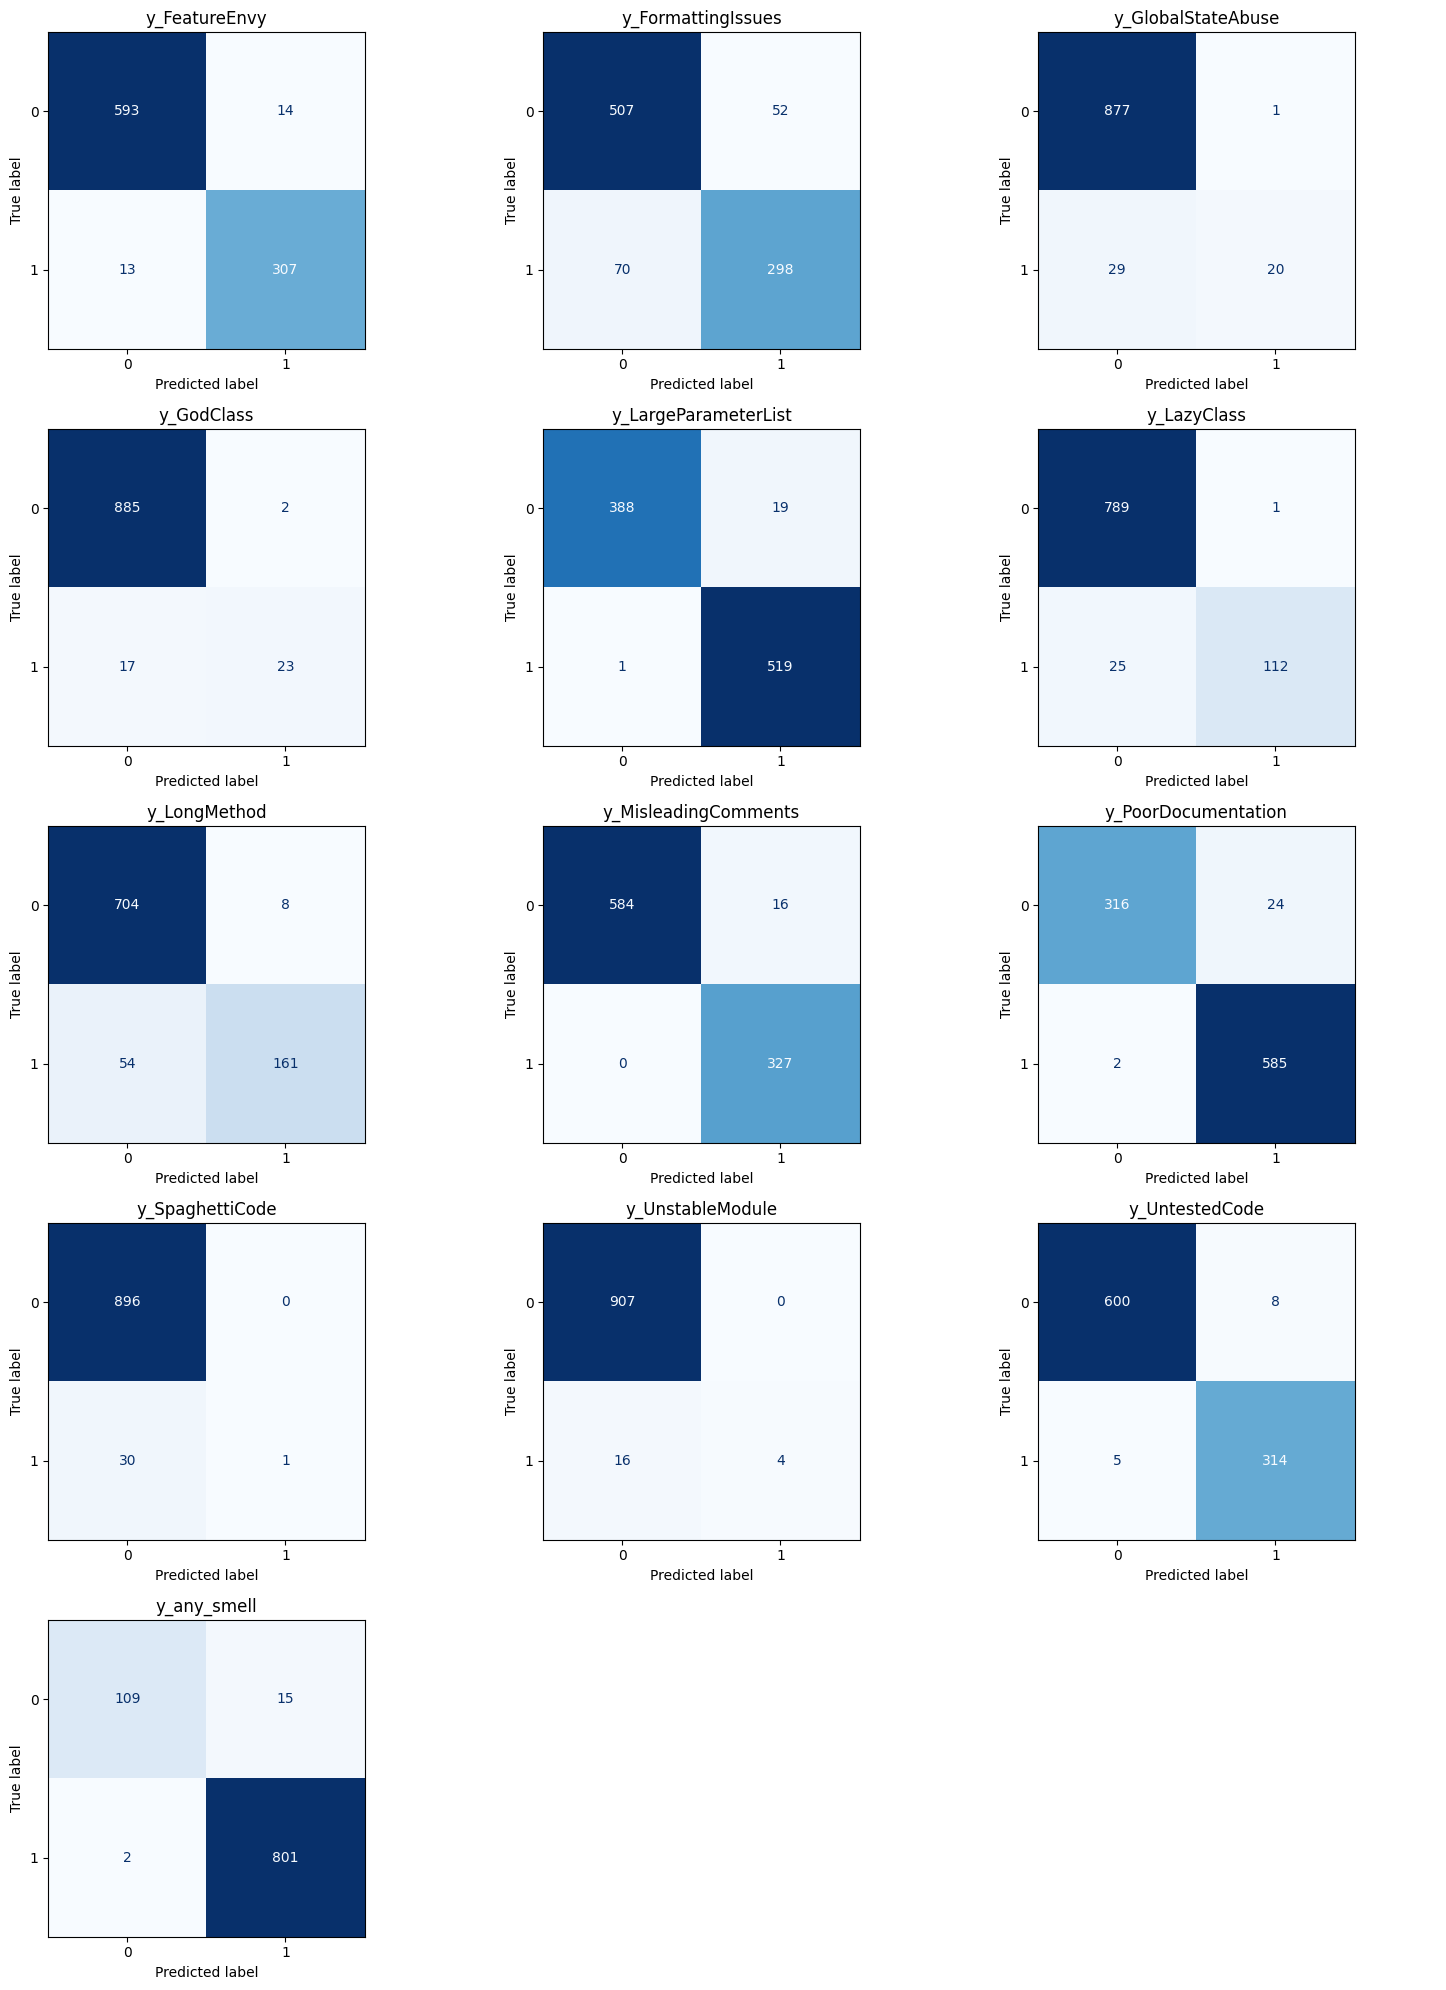

In [12]:
# Confusion Matrix Visualization
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

n_cols = 3
n_rows = math.ceil(len(target_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(target_cols):
    cm = confusion_matrix(Y_test[col], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(col)

for j in range(len(target_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig("../models/extra_trees_confusion_matrix.png", dpi=150)
plt.show()

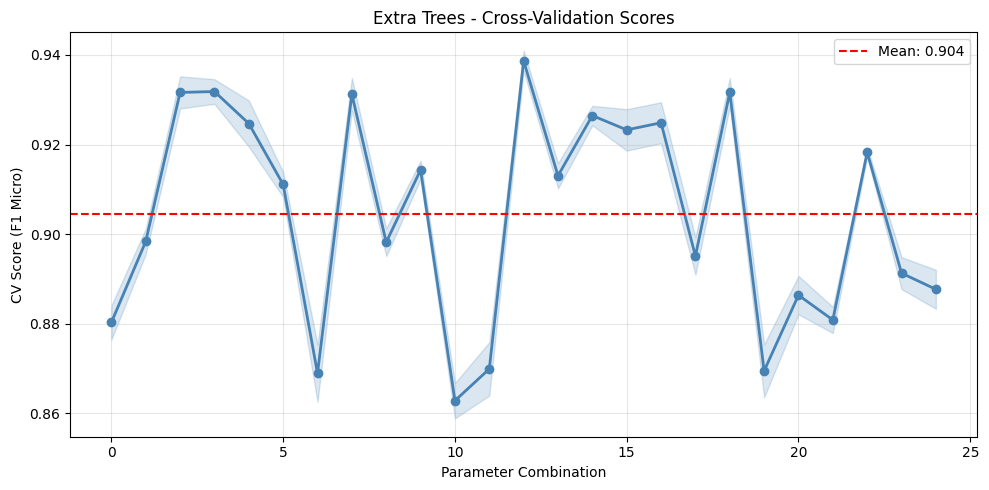

In [13]:
# Cross-Validation Scores Visualization
import matplotlib.pyplot as plt
import numpy as np

cv_scores = search.cv_results_["mean_test_score"]
cv_std = search.cv_results_["std_test_score"]

plt.figure(figsize=(10, 5))
x = np.arange(len(cv_scores))
plt.plot(x, cv_scores, marker="o", color="steelblue", linewidth=2, markersize=6)
plt.fill_between(x, cv_scores - cv_std, cv_scores + cv_std, alpha=0.2, color="steelblue")
plt.axhline(y=cv_scores.mean(), color="red", linestyle="--", label=f"Mean: {cv_scores.mean():.3f}")
plt.xlabel("Parameter Combination")
plt.ylabel("CV Score (F1 Micro)")
plt.title("Extra Trees - Cross-Validation Scores")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../models/extra_trees_cv_scores.png", dpi=150)
plt.show()

## Evaluate

In [14]:
# Average CV score across all tried parameter combinations
cv_mean_scores = search.cv_results_["mean_test_score"]
print("Average CV accuracy :", cv_mean_scores.mean())
print("CV accuracy std :", cv_mean_scores.std())

Average CV accuracy : 0.9044235058992248
CV accuracy std : 0.023384138007034663


## 6) Save model

In [15]:
# Step 8: Save model
from pathlib import Path
import pickle

models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / "extra_trees.pkl"
with open(model_path, "wb") as f:
    pickle.dump(et_model, f)

print("Extra Trees classifier saved successfully as pickle! ->", model_path)

Extra Trees classifier saved successfully as pickle! -> ../models/extra_trees.pkl
